In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from scipy.stats import multivariate_normal
import matplotlib.mlab as mlab
from matplotlib.patches import Ellipse
from scipy.stats import gaussian_kde
import scipy.ndimage as ndimage

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# def res_changer(vec_high_res, res_len_low):
#     sum_width = int(vec_high_res.shape[1]/res_len_low)
#     print(sum_width)
#     vec_low_res = np.zeros((vec_high_res.shape[0], res_len_low))
#     for i in range(vec_high_res.shape[0]):
#         for j in range(res_len_low):
#             vec_low_res[i,j] = np.sum(vec_high_res[i,j*sum_width:(j+1)*sum_width])
    
#     return vec_low_res

def ln_Gaussian_likelihood_no_norm(x, x_fid, cov, N_cov):
    H_factor = (N_cov - x.shape[0] - 2)/(N_cov - 1)
    power = -0.5*np.matmul(np.matmul(x-x_fid, H_factor*np.linalg.inv(cov)), x-x_fid)
    return power

def ln_gauss2d_no_norm(xy, x0, y0, a, c, b):  # a, c, b are from the inverse of the covariance matrix
    x, y = xy
    inner = a * (x - x0)**2
    inner += 2 * c * (x - x0) * (y - y0)
    inner += b * (y - y0)**2
    return -0.5*inner

def gauss2d(xy, mean, cov):
    x, y = xy
    x0 = mean[0]
    y0 = mean[1]
    inner = np.linalg.inv(cov)[0,0] * (x - x0)**2
    inner += 2 * np.linalg.inv(cov)[0,1] * (x - x0) * (y - y0)
    inner += np.linalg.inv(cov)[1,1] * (y - y0)**2
    return np.exp(-0.5*(inner + 2*np.log(2*np.pi) + np.log(np.linalg.det(cov))))

In [3]:
om_s8_list_fid = np.genfromtxt("om_s8_list_fid15000.txt", delimiter=",")
om_s8_list_swp = np.genfromtxt("om_s8_list_inference_swp3600x10.txt", delimiter=",")

In [5]:
a0      = 0.1       #the initial epoch from where we begin the evolution, a0=0 corresponds to birth but is numerically unstable
z       = 0.5
af      = 1.0 / (1.0 + z)       #final epoch where we visualize structures, af=1 corresponds to today
n_steps = 10        #number of time-steps to split the total evolution into
L       = 256       #Physical size of the Universe in Mpc/h
N       = 160        #Number of mesh-points along one axis, size of the cube. Then the number of particles will be N^3
batch   = 1         #Batch size, how many independent Universes to simulate

# arg_k_ = 5
# res_len = 64

baseDir = "64_w_shotnoise\\64\\"

vec_fid = []
for i in range(om_s8_list_fid.shape[0]):
    vec_fid.append(np.load(baseDir+"fs_{}_{}_{}_{}_{}_{}_{}_{}_fid_{}.npy".format(str(np.round(om_s8_list_fid[i,0], decimals=6)), str(np.round(om_s8_list_fid[i,1], decimals=6)), a0, z, n_steps, L, N, batch, str(int(om_s8_list_fid[i,-1])))))
vec_fid = np.array(vec_fid)

vec_swp = []
for i in range(om_s8_list_swp.shape[0]):
    vec_swp.append(np.load(baseDir+"fs_{}_{}_{}_{}_{}_{}_{}_{}_swp_{}.npy".format(str(np.round(om_s8_list_swp[i,0], decimals=6)), str(np.round(om_s8_list_swp[i,1], decimals=6)), a0, z, n_steps, L, N, batch, str(int(om_s8_list_swp[i,-1])))))
vec_swp = np.array(vec_swp)

k_max_ind = 19  # 0.3:11; 0.4:15; 0.5:19
N_fid = 10000

# ind = np.concatenate((np.arange(0,res_len*3),np.arange(res_len*6,res_len*9)))  # B+D
# ind = np.concatenate((np.arange(0,res_len*3),np.arange(res_len*3,res_len*6)))  # B+P
# vec_cov_raw = np.array(vec_fid)[N_fid:,:k_max_ind,1]
# vec_fid_raw = np.array(vec_fid)[:N_fid,:k_max_ind,1]
# vec_swp_raw = np.array(vec_swp)[:,:k_max_ind,1]

In [8]:
vec_fid_less_shot = np.copy(vec_fid)
print(len(vec_fid_less_shot))
for i in range(len(vec_fid_less_shot)):
    vec_fid_less_shot[i,:,1] = vec_fid_less_shot[i,:,1] - L**3/vec_fid_less_shot[i,0,2]

vec_swp_less_shot = np.copy(vec_swp)
print(len(vec_swp_less_shot))
for i in range(len(vec_swp_less_shot)):
    vec_swp_less_shot[i,:,1] = vec_swp_less_shot[i,:,1] - L**3/vec_swp_less_shot[i,0,2]

15000
36000


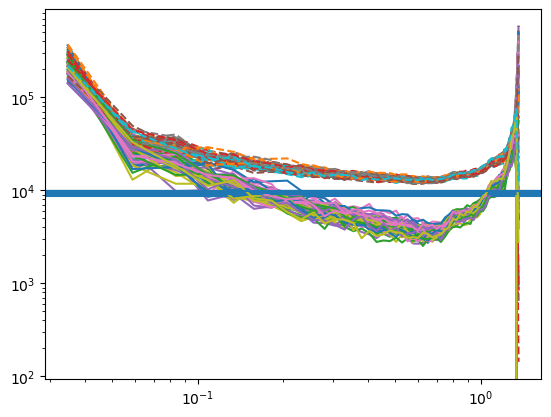

In [9]:
for which_PS in range(10000, 10050):
    plt.plot(vec_fid_less_shot[which_PS,:,0], vec_fid_less_shot[which_PS,:,1])
    plt.plot(vec_fid[which_PS,:,0], vec_fid[which_PS,:,1], ls="dashed")
    plt.axhline(L**3/vec_fid[which_PS,0,2])
    # plt.plot(vec_fid_less_shot[which_PS,:,0], vec_fid[which_PS,:,1]-vec_fid_less_shot[which_PS,:,1], ls="dashed", color="green")
# print(vec_fid[1,0,2])
# print(vec_fid[which_PS][0][2])
plt.xscale("log")
plt.yscale("log")
plt.show()

In [10]:
vec_cov_raw = vec_fid[N_fid:,:k_max_ind,1]
vec_fid_raw = vec_fid_less_shot[:N_fid,:k_max_ind,1]
vec_swp_raw = vec_swp_less_shot[:,:k_max_ind,1]

In [11]:
print(vec_cov_raw.shape)
print(vec_fid_raw.shape)
print(vec_swp_raw.shape)
print(vec_cov_raw[0,:])

(5000, 19)
(10000, 19)
(36000, 19)
[371901.1829381   39425.0830217   31963.69585805  23724.64393623
  17349.13386466  20031.93659009  16969.85551966  15685.11922163
  16930.45115686  16624.9101563   15549.64543082  14835.98671741
  15327.25215747  15179.02197595  14673.69648186  14228.48081059
  14636.3408691   14564.69697683  13861.12469092]


In [12]:
swp_mul = 10
avg_over = 10
om_s8_list_swp_avg = np.array([np.mean(om_s8_list_swp[i*swp_mul:i*swp_mul+avg_over,:], axis=0) for i in range(int(om_s8_list_swp.shape[0]/swp_mul))])
print(om_s8_list_swp_avg.shape)

(3600, 9)


In [13]:
vec_cov = np.copy(vec_cov_raw)
vec_fid = np.copy(vec_fid_raw)
vec_swp = np.copy(vec_swp_raw)

swp_mul = 10
avg_over = 10
vec_cov = np.array([np.mean(vec_cov[i*swp_mul:i*swp_mul+avg_over,:], axis=0) for i in range(int(vec_cov.shape[0]/swp_mul))])  #
vec_fid = np.array([np.mean(vec_fid[i*swp_mul:i*swp_mul+avg_over,:], axis=0) for i in range(int(vec_fid.shape[0]/swp_mul))])  #
vec_swp = np.array([np.mean(vec_swp[i*swp_mul:i*swp_mul+avg_over,:], axis=0) for i in range(int(vec_swp.shape[0]/swp_mul))])

# # Raw res is 64*3*2=576
# res_len_low = 96
# vec_cov = res_changer(vec_cov, res_len_low)
# vec_fid = res_changer(vec_fid, res_len_low)
# vec_swp = res_changer(vec_swp, res_len_low)
print(vec_cov.shape)
print(vec_fid.shape)
print(vec_swp.shape)

cov = np.cov(vec_cov.T)
corr = np.corrcoef(vec_cov.T)
print(0 in cov)
print(np.linalg.det(cov))

(500, 19)
(1000, 19)
(3600, 19)
False
2.900923273453365e+96


In [14]:
mean_pred_param_space_array = []
cov_pred_param_space_array = []
mean_pred_param_space_array_smoo = []
for j in range(vec_fid.shape[0]):
    print(j)
    post = np.zeros((int(np.sqrt(vec_swp.shape[0])),int(np.sqrt(vec_swp.shape[0]))))
    
    for i in range(vec_swp.shape[0]):
        # if i % 100 == 0:
        #     print(i)
        post[int(i%int(np.sqrt(vec_swp.shape[0]))), int(i/int(np.sqrt(vec_swp.shape[0])))] = ln_Gaussian_likelihood_no_norm(vec_swp[i], vec_fid[j], cov, vec_cov.shape[0])

    x = []
    y = []
    for i in range(60):
        for j in range(60):
            y.append(i)
            x.append(j)
    xy = (x, y)
    z = post.flatten()

    # guess = [x[z.argmax()], y[z.argmax()], 1, 1, 1]
    guess = [30, 30, 0.1, 0.1, 0.1]
    pred_params, uncert_cov = curve_fit(ln_gauss2d_no_norm, xy, z, p0=guess, maxfev=999999999)

    cov_inv_pred = np.array([[pred_params[2], pred_params[3]], [pred_params[3], pred_params[4]]])
    cov_pred = np.linalg.inv(cov_inv_pred)
    mean_pred = np.array([pred_params[0], pred_params[1]])
    # print(mean_pred[0]*(0.4089-0.2089)/60+0.2089)
    # print(mean_pred[1]*(0.9159-0.7159)/60+0.7159)
    # print(np.sqrt(cov_pred[0,0])*(0.4089-0.2089)/60)
    # print(np.sqrt(cov_pred[1,1])*(0.9159-0.7159)/60)
    mean_pred_param_space = np.array([pred_params[0]*(0.4089-0.2089)/60+0.2089, pred_params[1]*(0.9159-0.7159)/60+0.7159])
    cov_pred_param_space = np.array([[(np.sqrt(cov_pred[0,0])*(0.4089-0.2089)/60)**2, cov_pred[0,1]*((0.4089-0.2089)/60)*((0.9159-0.7159)/60)], [cov_pred[0,1]*((0.4089-0.2089)/60)*((0.9159-0.7159)/60), (np.sqrt(cov_pred[1,1])*(0.9159-0.7159)/60)**2]])
    # print(np.linalg.inv(cov_pred_param_space))

    # print(pred_params)
    # print(uncert_cov)
    # print(mean_pred_param_space)
    # print(cov_pred_param_space)

    mean_pred_param_space_array.append(mean_pred_param_space)
    cov_pred_param_space_array.append(cov_pred_param_space)

    # fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4)
    # fig.set_size_inches(13, 3)

    # # print(np.amin(post),np.amax(post))
    # ax0.imshow(post, origin='lower', cmap='binary')#, norm=mpl.colors.Normalize((np.amin(post)+np.amax(post))/2,np.amax(post)))
    # ax0.set_title("~ln(posterior)")
    # ax0.set_ylabel("s8")
    # ax0.set_xlabel("om")
    # ax0.set_xticks(np.linspace(0,59,5,endpoint=True), np.around(np.linspace(0.2089,0.4089,5,endpoint=True), decimals=3))
    # ax0.set_yticks(np.linspace(0,59,5,endpoint=True), np.around(np.linspace(0.7159,0.9159,5,endpoint=True), decimals=3))

    post = ndimage.gaussian_filter(post, sigma=0.2, order=0)
    max_ind = np.unravel_index(post.argmax(), post.shape)
    list_max_ind = max_ind[0]*60 + max_ind[1]
    om_smoo = om_s8_list_swp_avg[list_max_ind][0]
    s8_smoo = om_s8_list_swp_avg[list_max_ind][1]
    mean_pred_param_space_array_smoo.append(np.array([om_smoo, s8_smoo]))
    # ax1.imshow(post, origin='lower', cmap='binary')#, norm=mpl.colors.Normalize((np.amin(post)+np.amax(post))/2,np.amax(post)))
    # ax1.set_title("~ln(posterior)")
    # ax1.set_ylabel("s8")
    # ax1.set_xlabel("om")
    # ax1.set_xticks(np.linspace(0,59,5,endpoint=True), np.around(np.linspace(0.2089,0.4089,5,endpoint=True), decimals=3))
    # ax1.set_yticks(np.linspace(0,59,5,endpoint=True), np.around(np.linspace(0.7159,0.9159,5,endpoint=True), decimals=3))

    # z_pred = ln_gauss2d_no_norm(xy, *pred_params)
    # # z_pred = gauss2d(xy, mean_pred_param_space, cov_pred_param_space)
    # z_pred = np.array(z_pred).reshape(60,60)
    # # print(z_pred.shape)
    # ax2.imshow(z_pred, origin='lower', cmap='binary')#, norm=mpl.colors.Normalize((np.amin(post)+3*np.amax(post))/4,np.amax(post)))
    # ax2.set_title("~ln(posterior)")
    # ax2.set_ylabel("s8")
    # ax2.set_xlabel("om")
    # ax2.set_xticks(np.linspace(0,59,5,endpoint=True), np.around(np.linspace(0.2089,0.4089,5,endpoint=True), decimals=3))
    # ax2.set_yticks(np.linspace(0,59,5,endpoint=True), np.around(np.linspace(0.7159,0.9159,5,endpoint=True), decimals=3))

    # a2 = (cov_pred_param_space[0,0] + cov_pred_param_space[1,1]) / 2 + np.sqrt((cov_pred_param_space[0,0] - cov_pred_param_space[1,1])**2 / 4 + cov_pred_param_space[0,1]**2)
    # b2 = (cov_pred_param_space[0,0] + cov_pred_param_space[1,1]) / 2 - np.sqrt((cov_pred_param_space[0,0] - cov_pred_param_space[1,1])**2 / 4 + cov_pred_param_space[0,1]**2)
    # tan2th = 2 * cov_pred_param_space[0,1] / (cov_pred_param_space[0,0] - cov_pred_param_space[1,1])
    # a = np.sqrt(a2)
    # b = np.sqrt(b2)
    # th = np.degrees(np.arctan(tan2th) / 2)
    # th = np.degrees(np.arctan2(2 * cov_pred_param_space[0,1], cov_pred_param_space[0,0] - cov_pred_param_space[1,1]) / 2)
    # alpha = [0, 1.52, 2.48, 3.44]
    # ellipse = Ellipse(xy=(mean_pred_param_space[0], mean_pred_param_space[1]), width=alpha[3]*a*2, height=alpha[3]*b*2, angle=th, color="green", alpha=0.2)
    # ax3.add_patch(ellipse)
    # ellipse = Ellipse(xy=(mean_pred_param_space[0], mean_pred_param_space[1]), width=alpha[2]*a*2, height=alpha[2]*b*2, angle=th, color="green", alpha=0.5)
    # ax3.add_patch(ellipse)
    # ellipse = Ellipse(xy=(mean_pred_param_space[0], mean_pred_param_space[1]), width=alpha[1]*a*2, height=alpha[1]*b*2, angle=th, color="green", alpha=1)
    # ax3.add_patch(ellipse)
    # ax3.scatter(mean_pred_param_space[0], mean_pred_param_space[1], marker="x", color="black", label="mean_posterior")
    # ax3.scatter(0.3089, 0.8159, marker="*", color="black", label="truth")
    # ax3.scatter(om_smoo, s8_smoo, marker="*", color="red", label="smoothed")
    # ax3.set_title("posterior")
    # ax3.set_ylabel("s8")
    # ax3.set_xlabel("om")
    # ax3.legend()
    # x_left, x_right = ax3.get_xlim()
    # y_low, y_high = ax3.get_ylim()
    # ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high)))
    
    # plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [15]:
means = np.array(mean_pred_param_space_array_smoo)
# covs = np.array(cov_pred_param_space_array_smoo)
np.save("means_10_smoo_s0.2_15000_PS_0.5",means)
# np.save("covs_10_smoo",covs)

In [16]:
# means = np.load("means_10_smoo_s3_15000_PS.npy")
# means2 = np.load("means_10_smoo_s2_15000_PS.npy")
# means4 = np.load("means_10_smoo_s4_15000_PS.npy")
# means1 = np.load("means_10_smoo_s1_15000_PS.npy")
# means05 = np.load("means_10_smoo_s0.5_15000_PS.npy")
# means03 = np.load("means_10_smoo_s0.3_15000_PS.npy")
means02 = np.load("means_10_smoo_s0.2_15000_PS_0.5.npy")
# means01 = np.load("means_10_smoo_s0.1_15000_PS.npy")
# means005 = np.load("means_10_smoo_s0.05_15000_PS.npy")
# covs = np.load("covs_10.npy")

In [79]:
print(np.sum(np.around(means4[:,0], decimals=4)==0.4089))
print(np.sum(np.around(means4[:,1], decimals=4)==0.9159))
print(np.sum(np.around(means[:,0], decimals=4)==0.4089))
print(np.sum(np.around(means[:,1], decimals=4)==0.9159))
print(np.sum(np.around(means2[:,0], decimals=4)==0.4089))
print(np.sum(np.around(means2[:,1], decimals=4)==0.9159))
print(np.sum(np.around(means1[:,0], decimals=4)==0.4089))
print(np.sum(np.around(means1[:,1], decimals=4)==0.9159))
print(np.sum(np.around(means05[:,0], decimals=4)==0.4089))
print(np.sum(np.around(means05[:,1], decimals=4)==0.9159))
print(np.sum(np.around(means03[:,0], decimals=4)==0.4089))
print(np.sum(np.around(means03[:,1], decimals=4)==0.9159))
print(np.sum(np.around(means02[:,0], decimals=4)==0.4089))
print(np.sum(np.around(means02[:,1], decimals=4)==0.9159))
print(np.sum(np.around(means01[:,0], decimals=4)==0.4089))
print(np.sum(np.around(means01[:,1], decimals=4)==0.9159))
print(np.sum(np.around(means005[:,0], decimals=4)==0.4089))
print(np.sum(np.around(means005[:,1], decimals=4)==0.9159))

649
50
475
44
321
28
159
11
65
6
27
1
26
1
26
1
26
1


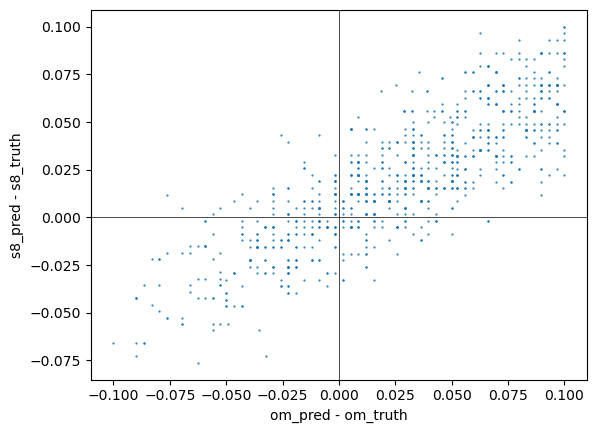

In [17]:
# plt.scatter(means4[:,0]-0.3089, means4[:,1]-0.8159,s=0.3)
# plt.scatter(means[:,0]-0.3089, means[:,1]-0.8159,s=0.3)
# plt.scatter(means2[:,0]-0.3089, means2[:,1]-0.8159,s=0.3)
# plt.scatter(means1[:,0]-0.3089, means1[:,1]-0.8159,s=0.3)
# plt.scatter(means05[:,0]-0.3089, means05[:,1]-0.8159,s=0.3)
# plt.scatter(means05[:,0]-0.3089, means05[:,1]-0.8159,s=0.3)
plt.scatter(means02[:,0]-0.3089, means02[:,1]-0.8159,s=0.3)
# plt.scatter(means01[:,0]-0.3089, means01[:,1]-0.8159,s=0.3)
plt.axvline(0,c="black",lw=0.5)
plt.axhline(0,c="black",lw=0.5)
# plt.xlim(-0.025,0.025)
# plt.ylim(-0.025,0.025)
plt.ylabel("s8_pred - s8_truth")
plt.xlabel("om_pred - om_truth")
plt.show()

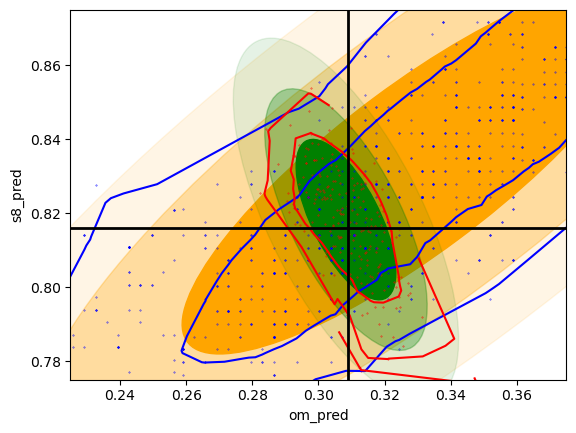

In [82]:
a = means02[:,0]
b = means02[:,1]
ab = np.vstack([a,b])
c = gaussian_kde(ab)(ab)
c = (c - c.min())/(c.max() - c.min())

means_ml = np.array([np.load("Om_test_3.npy"), np.load("s8_test_3.npy")]).T
d = means_ml[:,0]
e = means_ml[:,1]
de = np.vstack([d,e])
f = gaussian_kde(de)(de)
f = (f - f.min())/(f.max() - f.min())

fig, ax = plt.subplots()


cov_error = np.cov(np.array([a, b]))
mean_error = np.mean(np.array([a, b]).T, axis=0)
# print(mean_error)
a2 = (cov_error[0,0] + cov_error[1,1]) / 2 + np.sqrt((cov_error[0,0] - cov_error[1,1])**2 / 4 + cov_error[0,1]**2)
b2 = (cov_error[0,0] + cov_error[1,1]) / 2 - np.sqrt((cov_error[0,0] - cov_error[1,1])**2 / 4 + cov_error[0,1]**2)
tan2th = 2 * cov_error[0,1] / (cov_error[0,0] - cov_error[1,1])
a3 = np.sqrt(a2)
b3 = np.sqrt(b2)
th = np.degrees(np.arctan(tan2th) / 2)
th = np.degrees(np.arctan2(2 * cov_error[0,1], cov_error[0,0] - cov_error[1,1]) / 2)
alpha = [0, 1.52, 2.48, 3.44]
ellipse = Ellipse(xy=(mean_error[0], mean_error[1]), width=alpha[3]*a3*2, height=alpha[3]*b3*2, angle=th, color="orange", alpha=0.1)
ax.add_patch(ellipse)
ellipse = Ellipse(xy=(mean_error[0], mean_error[1]), width=alpha[2]*a3*2, height=alpha[2]*b3*2, angle=th, color="orange", alpha=0.3)
ax.add_patch(ellipse)
ellipse = Ellipse(xy=(mean_error[0], mean_error[1]), width=alpha[1]*a3*2, height=alpha[1]*b3*2, angle=th, color="orange", alpha=1)
ax.add_patch(ellipse)

cov_error = np.cov(np.array([d, e]))
mean_error = np.mean(np.array([d, e]).T, axis=0)
# print(mean_error)
a2 = (cov_error[0,0] + cov_error[1,1]) / 2 + np.sqrt((cov_error[0,0] - cov_error[1,1])**2 / 4 + cov_error[0,1]**2)
b2 = (cov_error[0,0] + cov_error[1,1]) / 2 - np.sqrt((cov_error[0,0] - cov_error[1,1])**2 / 4 + cov_error[0,1]**2)
tan2th = 2 * cov_error[0,1] / (cov_error[0,0] - cov_error[1,1])
a3 = np.sqrt(a2)
b3 = np.sqrt(b2)
th = np.degrees(np.arctan(tan2th) / 2)
th = np.degrees(np.arctan2(2 * cov_error[0,1], cov_error[0,0] - cov_error[1,1]) / 2)
alpha = [0, 1.52, 2.48, 3.44]
ellipse = Ellipse(xy=(mean_error[0], mean_error[1]), width=alpha[3]*a3*2, height=alpha[3]*b3*2, angle=th, color="green", alpha=0.1)
ax.add_patch(ellipse)
ellipse = Ellipse(xy=(mean_error[0], mean_error[1]), width=alpha[2]*a3*2, height=alpha[2]*b3*2, angle=th, color="green", alpha=0.3)
ax.add_patch(ellipse)
ellipse = Ellipse(xy=(mean_error[0], mean_error[1]), width=alpha[1]*a3*2, height=alpha[1]*b3*2, angle=th, color="green", alpha=1)
ax.add_patch(ellipse)

# ax.scatter(a, b, c=c, s=3)
ax.scatter(a, b, c="blue", s=0.1)
ax.tricontour(a, b, c, [0.003, 0.05, 0.32], linewidths=1.5, colors='blue')

ax.scatter(d, e, c="red", s=0.1)
ax.tricontour(d, e, f, [0.003, 0.05, 0.32], linewidths=1.5, colors='red')

ax.axvline(0+0.3089,c="black",lw=2)
ax.axhline(0+0.8159,c="black",lw=2)

ax.set_ylim(0.775,0.875)
ax.set_xlim(0.225,0.375)
ax.set_ylabel("s8_pred")
ax.set_xlabel("om_pred")

plt.show()